# Prédiction du prix des voitures

- [Youtube - 2.1 à 2.16](https://www.youtube.com/watch?v=vM3SqPNlStE&list=PL3MmuxUbc_hIhxl5Ji8t4O6lPAOpHaCLR&index=11)
- [Github - Notebook](https://github.com/alexeygrigorev/mlbookcamp-code/tree/master/chapter-02-car-price)
- [Github - DataTalksClub](https://github.com/DataTalksClub/machine-learning-zoomcamp/tree/master/02-regression)

On va chercher à créer un outil pour aider les gens à estimer le prix d'une voiture. Pour cela, on va analyser des données pour pouvoir construire un modèle de régression capable d'estimer le prix d'une voiture à partir de différentes informations. Le jeu de données utilisé provient du site [Kaggle](https://www.kaggle.com/datasets/CooperUnion/cardataset).
- Préparer des données et réaliser d'une analyse exploratoire
- Utiliser une régression linéaire pour prédire le prix
- Comprendre ce qui se passe dans ce modèle et comment il peut prédire un prix.
- Utiliser le RMSE pour évaluer notre modèle
- Réaliser du feature engineering
- Utiliser la régularisation pour régler des problèmes en lien avec le modèle.
- Utiliser le modèle.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### 1) Préparation des données

In [2]:
df = pd.read_csv("data/data.csv")
df.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


La première étape est de rendre les données consistantes en mettant le nom des colonnes sous le même format (remplacement des espaces par des underscores, passage en minuscule partout).

In [3]:
df.columns = df.columns.str.lower().str.replace(" ", "_")
df.head(1)

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135


On standardise aussi les valeurs présentes dans le dataframe et plus particulièrement dans les variables sous forme de string (ou *object*).

In [4]:
strings = list(df.dtypes[df.dtypes == "object"].index)
strings

['make',
 'model',
 'engine_fuel_type',
 'transmission_type',
 'driven_wheels',
 'market_category',
 'vehicle_size',
 'vehicle_style']

In [5]:
for i in strings:
    df[i] = df[i].str.lower().str.replace(" ", "_")

In [6]:
df.head()

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
0,bmw,1_series_m,2011,premium_unleaded_(required),335.0,6.0,manual,rear_wheel_drive,2.0,"factory_tuner,luxury,high-performance",compact,coupe,26,19,3916,46135
1,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,convertible,28,19,3916,40650
2,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,high-performance",compact,coupe,28,20,3916,36350
3,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,coupe,28,18,3916,29450
4,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,luxury,compact,convertible,28,18,3916,34500


### 2) Analyse exploratoire des données

On va s'intéresser au contenu de nos features. Pour chaque colonne, on va afficher les 5 premières valeurs ainsi que le nombre total de valeurs pour chaque variable. 

In [7]:
for col in df.columns:
    print(col)
    print(f"{df[col].unique()[:5]}")
    print(f"{df[col].nunique()}\n")

make
['bmw' 'audi' 'fiat' 'mercedes-benz' 'chrysler']
48

model
['1_series_m' '1_series' '100' '124_spider' '190-class']
914

year
[2011 2012 2013 1992 1993]
28

engine_fuel_type
['premium_unleaded_(required)' 'regular_unleaded'
 'premium_unleaded_(recommended)' 'flex-fuel_(unleaded/e85)' 'diesel']
10

engine_hp
[335. 300. 230. 320. 172.]
356

engine_cylinders
[ 6.  4.  5.  8. 12.]
9

transmission_type
['manual' 'automatic' 'automated_manual' 'direct_drive' 'unknown']
5

driven_wheels
['rear_wheel_drive' 'front_wheel_drive' 'all_wheel_drive'
 'four_wheel_drive']
4

number_of_doors
[ 2.  4.  3. nan]
3

market_category
['factory_tuner,luxury,high-performance' 'luxury,performance'
 'luxury,high-performance' 'luxury' 'performance']
71

vehicle_size
['compact' 'midsize' 'large']
3

vehicle_style
['coupe' 'convertible' 'sedan' 'wagon' '4dr_hatchback']
16

highway_mpg
[26 28 27 25 24]
59

city_mpg
[19 20 18 17 16]
69

popularity
[3916 3105  819  617 1013]
48

msrp
[46135 40650 36350 29450 345

- Distribution des prix

On va ensuite analyser la distribution des prix (notre cible). 

<Axes: xlabel='msrp', ylabel='Count'>

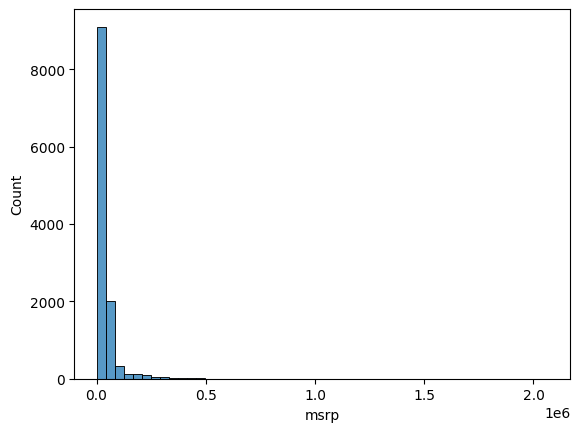

In [8]:
sns.histplot(df.msrp, bins=50)

*Ressource*
- [Long Tail Distribution definition](https://www.statology.org/long-tail-distribution/)

<Axes: xlabel='msrp', ylabel='Count'>

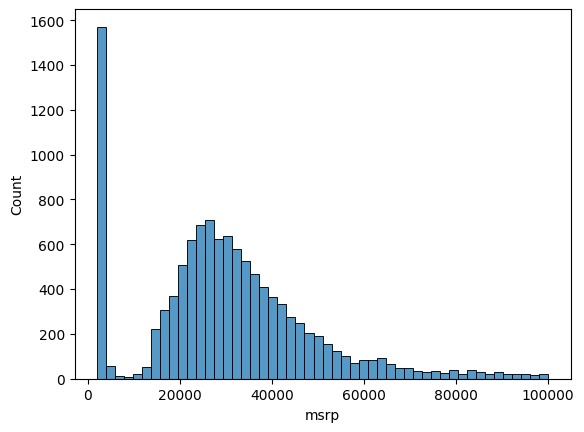

In [9]:
sns.histplot(df.msrp[df.msrp < 100000], bins=50)

La distribution des valeurs à prédire n'est pas idéale pour y appliquer des modèles de machine learning. On a affaire à une distribution avec une longue traîne (long tail distribution). Cela signifie qu'il y a quelques valeurs qui s'éloignent de la majorité. On a pu voir que si on limite le choix à des véhicules dont le prix est inférieur à 100000, on n'observe plus ce phénomène. On ne peut pas supprimer les valeurs qui sont supérieurs à cette somme, on va donc appliquer une transformation logarithmique pour rendre la distribution des prix plus facilement exploitables dans le cadre d'un modèle de machine learning.

In [10]:
# transformation logarithmique via Numpy
price_logs = np.log1p(df.msrp)

# représentation graphique
sns.histplot(price_logs, bins=50)

- Valeurs manquantes

Enfin, on cherche à savoir quelle variable possède des valeurs manquantes.

In [12]:
df.isnull().sum()

make                    0
model                   0
year                    0
engine_fuel_type        3
engine_hp              69
engine_cylinders       30
transmission_type       0
driven_wheels           0
number_of_doors         6
market_category      3742
vehicle_size            0
vehicle_style           0
highway_mpg             0
city_mpg                0
popularity              0
msrp                    0
dtype: int64

### 3) Préparation des différents jeux de données

In [13]:
n = len(df)
n_val = int(len(df) * 0.2)
n_test = int(len(df) * 0.2)
n_train = n - n_val - n_test

In [14]:
n_val, n_test, n_train

(2382, 2382, 7150)

In [15]:
df_train = df.iloc[:n_train]
df_val = df.iloc[n_train:n_train+n_val]
df_test = df.iloc[n_train+n_val:]

In [16]:
idx = np.arange(n)
np.random.seed(2)
np.random.shuffle(idx)

df_shuffled = df.iloc[idx]

In [17]:
df_train = df_shuffled.iloc[idx[:n_train]].copy()
df_val = df_shuffled.iloc[idx[n_train:n_train+n_val]].copy()
df_test = df_shuffled.iloc[idx[n_train+n_val:]].copy()

In [18]:
df_train.head()

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
7077,ford,mustang,2015,premium_unleaded_(recommended),310.0,4.0,manual,rear_wheel_drive,2.0,high-performance,midsize,coupe,31,22,5657,29300
982,mazda,929,1994,regular_unleaded,193.0,6.0,automatic,rear_wheel_drive,4.0,NaN,midsize,sedan,22,17,586,2000
142,bmw,3_series,2015,diesel,180.0,4.0,automatic,all_wheel_drive,4.0,"diesel,luxury",midsize,sedan,43,31,3916,41000
11624,volvo,xc90,2014,regular_unleaded,240.0,6.0,automatic,front_wheel_drive,4.0,"crossover,luxury",midsize,4dr_suv,25,16,870,42700
8570,nissan,rogue_select,2015,regular_unleaded,170.0,4.0,automatic,all_wheel_drive,4.0,crossover,midsize,4dr_suv,27,22,2009,21500


In [19]:
len(df_train), len(df_val), len(df_test)

(7150, 2382, 2382)

In [20]:
df_train = df_train.reset_index(drop = True)
df_val = df_val.reset_index(drop = True)
df_test = df_test.reset_index(drop = True)

In [21]:
df_train.head()

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
0,ford,mustang,2015,premium_unleaded_(recommended),310.0,4.0,manual,rear_wheel_drive,2.0,high-performance,midsize,coupe,31,22,5657,29300
1,mazda,929,1994,regular_unleaded,193.0,6.0,automatic,rear_wheel_drive,4.0,NaN,midsize,sedan,22,17,586,2000
2,bmw,3_series,2015,diesel,180.0,4.0,automatic,all_wheel_drive,4.0,"diesel,luxury",midsize,sedan,43,31,3916,41000
3,volvo,xc90,2014,regular_unleaded,240.0,6.0,automatic,front_wheel_drive,4.0,"crossover,luxury",midsize,4dr_suv,25,16,870,42700
4,nissan,rogue_select,2015,regular_unleaded,170.0,4.0,automatic,all_wheel_drive,4.0,crossover,midsize,4dr_suv,27,22,2009,21500


In [22]:
y_train = np.log1p(df_train["msrp"].values)
y_val = np.log1p(df_val["msrp"].values)
y_test = np.log1p(df_test["msrp"].values)

In [23]:
del df_train["msrp"]
del df_val["msrp"]
del df_test["msrp"]

273

In [24]:
len(y_train)

7150

### 4) Régression linéaire

C'est un modèle que l'on utilise pour résoudre des problèmes de régression. On peut modéliser notre problème sous cette forme $g(X) = y$ avec : 
- *g* est notre modèle (régression linéaire)
- *X* les caractèristiques des voitures
- *y* les prix

On cherchera à avoir une fonction qui prendra $x_{i1}, x_{i2},..., x_{in}$ pour deviner les prix $y_{i1}, y_{i2}, ..., y_{in}$.

Par exemple :

On part du principe que l'on n'a besoin que de trois caractéristiques d'une voiture pour estimer son prix : la puissance, la consommation en ville et sa popularité. On représentera ces informations sous cette forme :  $x_i = [453, 11, 86]$. Pour ce cas précis, on aura une régression linéaire sous cette forme : $g(x_{i}) = w_0 + w_1 \times x_{i1} + w_2 \times x_{i2} + w_3 \times x_{i3}$ avec :
- $w_0$ l'intercept, c'est-à-dire la valeur de y quand X est égale à 0.
- $w_1, w_2$ et $w_3$ : les poids (ou coefficients associés à des valeurs $x_i$)
- $x_{i1}, x_{i2}$ et $x_{i3}$ : les valeurs des caractéristiques de la voiture (puissance, consommation en ville et popularité).

La généralisation de la formule s'écrit de la manière suivante :
$g(x_i) = w_0 + \sum\limits_{j = 1}^n (w_j \cdot x_{ij})$

In [25]:
df_train.iloc[10]

make                         chevrolet
model                          venture
year                              2003
engine_fuel_type      regular_unleaded
engine_hp                        185.0
engine_cylinders                   6.0
transmission_type            automatic
driven_wheels        front_wheel_drive
number_of_doors                    4.0
market_category                    NaN
vehicle_size                   midsize
vehicle_style        passenger_minivan
highway_mpg                         24
city_mpg                            17
popularity                        1385
Name: 10, dtype: object

In [26]:
xi = [185, 17, 1385]

In [27]:
w0 = 7.17
w = [0.01, 0.04, 0.002]

In [28]:
def linear_regression(xi):
    n = len(xi)
    
    pred = w0
    
    for j in range(n):
        pred = pred + w[j] * xi[j]
    
    return pred

In [29]:
linear_regression(xi)

12.469999999999999

In [30]:
np.expm1(12.46999)

260403.11713451715

### 5) Généralisation sous forme de vecteur

Si on reprend cette formule : $g(x_i) = w_0 + \sum\limits_{j = 1}^n (w_j \cdot x_{ij})$. La partie après la somme est un produit scalaire. On peut donc réécrire la formule de cette manière $g(x_i) = w_0 + x_i^T \cdot w_j$. L'implémentation en Python de cette formule est la suivante : 

Le vecteur w possède cette forme $W = [ w_0, w_1, w_2, ..., w_n]$ et le vecteur $X_i$ est égale à $X_i = [ X_{i0}, X_{i1}, X_{i2}, ..., X_{in}]$. On peut donc écrire :
$W^T \cdot X_i = X_i^T \cdot W$. 
Après cette simplification d'écriture, on peut passer à la généralisation pour chaque voiture. Cette généralisation représente une multiplication entre une matrice X contenant les différentes caractéristiques de nos voitures et un vecteur w qui contient les poids à attribuer à ligne. Le produit scalaire de la matrice X par le vecteur w donne un vecteur y qui correspond aux prix des voitures.

$$
X =
\begin{bmatrix}
1 & X_{11} & X_{22} & ... & X_{1n}\\
1 & X_{21} & X_{22} & ... & X_{2n}\\
1 & & ...& \\
1 & X_{m1} & X_{m2} & ... & X_{mn}
\end{bmatrix}

\cdot

\begin{bmatrix}
w_0\\
w_1\\
...\\
w_n
\end{bmatrix}

= 

\begin{bmatrix}
X_1^T \cdot w\\
X_2^T \cdot w\\
...\\
X_m^T \cdot w
\end{bmatrix}
$$

In [31]:
def dot(xi, w):
    n = len(xi)
    
    res = 0.0
    
    for j in range(n):
        res = res + xi[j] * w[j]

    return res

In [32]:
def linear_regression(xi):
    return w0 + dot(xi, w)

In [33]:
w_new = [w0] + w
w_new

[7.17, 0.01, 0.04, 0.002]

In [34]:
def linear_regression(xi):
    xi = [1] + xi
    return dot(xi, w_new)

In [35]:
linear_regression(xi)

12.469999999999999

In [36]:
w0 = 7.17
w = [0.01, 0.04, 0.002]
w_new = [w0] + w

In [37]:
x1 = [1, 148, 24, 1385]
x2 = [1, 132, 24, 2031]
x10 = [1, 453, 11, 86]

X = [x1, x2, x10]
X = np.array(X)
X

array([[   1,  148,   24, 1385],
       [   1,  132,   24, 2031],
       [   1,  453,   11,   86]])

In [38]:
def linear_regression(X):
    return X.dot(w_new)

In [39]:
linear_regression(X)

array([12.38 , 13.512, 12.312])

## 6) Entraînement d'un modèle de régression linéaire

Dans cette partie, on va s'intéresser aux différents poids w que l'on a vu précédemment. On va chercher à comprendre comment les déterminer.
On cherche à s'approcher le plus possible de la valeur *y*. On va chercher à résoudre le système suivant : $X_w = y$. Si on considère que X est orthogonal, il existe une inverse à cette matrice. On a donc : $w = X^{-1} y$. Cependant, la plupart du temps X  est rectangulaire (elle possède beaucoup de lignes et un peu moins de colonnes) donc il n'existe pas d'inverse et aucune solution existe. Dans ce cas, on va faire une approximation de la solution de la manière suivante : $X^TX_w = X^Ty$. On appelle matrice de Gram $X^TX_w$. Les propriétés de la matrice de Gram la rendent orthogonale et il est possible de l'inverser. On aura ensuite : 
$(X^TX)^{-1}X^TX_w = (X^TX)^{-1}X^Ty$. Il est possible de simplifier pour obtenir : $w = (X^TX)^{-1}X^Ty$. w n'est pas une solution à ce système car il n'existe pas de solution mais il s'agit d'une approximation de la solution.

In [40]:
X = [
    [148, 24, 1385],
    [132, 25, 2031],
    [453, 11, 86],
    [158, 24, 185],
    [148, 25, 201],
    [413, 11, 86],
    [38,  54, 1085],
    [142, 25, 31],
    [453, 31, 86]
]

X = np.array(X)

In [41]:
y = [10000, 20000, 15000, 20050, 10000, 20000, 15000, 25000, 12000]

 $w = (X^TX)^{-1}X^Ty$

In [42]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    
    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [43]:
train_linear_regression(X, y)

(24623.4082166091, array([ -14.62710177, -156.38326613,   -1.563952  ]))

### 7) Modèle baseline

In [44]:
base = ['engine_hp', 'engine_cylinders', 'highway_mpg',
        'city_mpg', 'popularity']

In [45]:
X_train = df_train[base].values

In [46]:
X_train = df_train[base].fillna(0).values

In [47]:
w0, w = train_linear_regression(X_train, y_train)

In [48]:
y_pred = w0 + X_train.dot(w)

<Axes: ylabel='Count'>

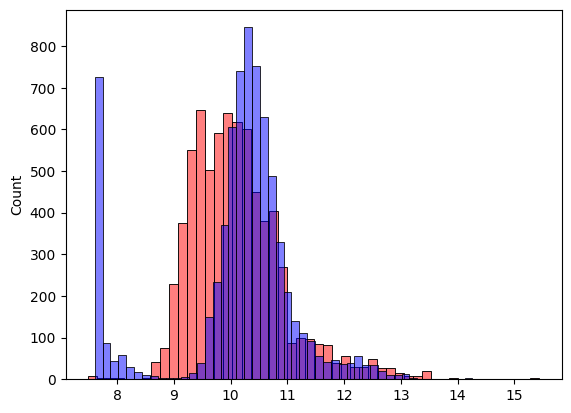

In [49]:
sns.histplot(y_pred, color='red', alpha=0.5, bins=50)
sns.histplot(y_train, color='blue', alpha=0.5, bins=50)

## 8) RMSE

On va tout d'abord faire la différence au carré (SE) : $g(x_i) - y_i$ avec :
- $g(x_i)$ la prédiction
- $y_i$ le prix réel.

Ensuite, on prend cette différence que l'on élève au carré : $[g(x_i) - y_i]^2$. On calcule la moyenne des différences au carré. Enfin, on calcule la racine carrée de cette moyenne. La formule du RMSE est la suivante : $\sqrt{\frac{1}{m}\sum(g(x_i) - y_i)^2}$.

In [50]:
def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [51]:
rmse(y_train, y_pred)

0.7509314240566245

## 9) Validation du modèle

In [52]:
def prepare_X(df):
    df_num = df[base]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [53]:
X_train = prepare_X(df_train)
w0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val)
y_pred = w0 + X_val.dot(w)

rmse(y_val, y_pred)

0.7565398314903737

## 10) Feature engineering

In [54]:
def prepare_X(df):
    df = df.copy()
    
    df['age'] = 2017 - df.year
    features = base + ['age']
    
    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [55]:
X_train = prepare_X(df_train)
w0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val)
y_pred = w0 + X_val.dot(w)

rmse(y_val, y_pred)

0.5073991348019624

<Axes: ylabel='Count'>

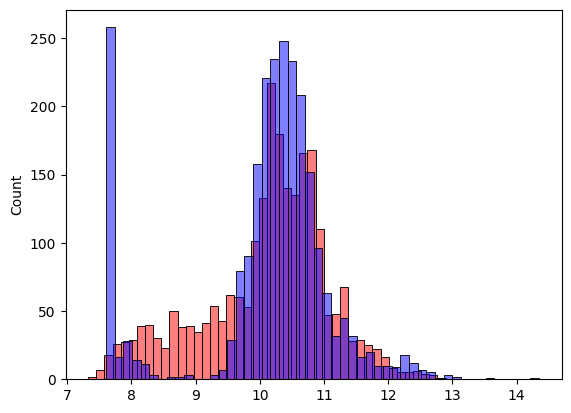

In [56]:
sns.histplot(y_pred, color='red', alpha=0.5, bins=50)
sns.histplot(y_val, color='blue', alpha=0.5, bins=50)

### 11) Variables catégorielles

In [57]:
def prepare_X(df):
    df = df.copy()
    features = base.copy()
    
    df['age'] = 2017 - df.year
    features.append('age')
    
    for v in [2, 3, 4]:
        df[f'num_doors_{v}'] = (df.number_of_doors == v).astype('int')
        features.append(f'num_doors_{v}')
    
    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [58]:
X_train = prepare_X(df_train)
w0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val)
y_pred = w0 + X_val.dot(w)

rmse(y_val, y_pred)

0.5054589415848046

In [59]:
makes = list(df.make.value_counts().head().index)

In [60]:
def prepare_X(df):
    df = df.copy()
    features = base.copy()
    
    df['age'] = 2017 - df.year
    features.append('age')
    
    for v in [2, 3, 4]:
        df[f'num_doors_{v}'] = (df.number_of_doors == v).astype('int')
        features.append(f'num_doors_{v}')
        
        
    for v in makes:
        df[f'make_{v}'] = (df.make == v).astype('int')
        features.append(f'make_{v}')
    
    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [61]:
X_train = prepare_X(df_train)
w0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val)
y_pred = w0 + X_val.dot(w)

rmse(y_val, y_pred)

0.49740290035401397

In [62]:
categorical_variables = ['make', 'engine_fuel_type', 'transmission_type', 'driven_wheels',
'market_category', 'vehicle_size', 'vehicle_style']

In [63]:
categories = {}

for c in categorical_variables:
    categories[c] = list(df[c].value_counts().head().index)

In [64]:
categories

{'make': ['chevrolet', 'ford', 'volkswagen', 'toyota', 'dodge'],
 'engine_fuel_type': ['regular_unleaded',
  'premium_unleaded_(required)',
  'premium_unleaded_(recommended)',
  'flex-fuel_(unleaded/e85)',
  'diesel'],
 'transmission_type': ['automatic',
  'manual',
  'automated_manual',
  'direct_drive',
  'unknown'],
 'driven_wheels': ['front_wheel_drive',
  'rear_wheel_drive',
  'all_wheel_drive',
  'four_wheel_drive'],
 'market_category': ['crossover',
  'flex_fuel',
  'luxury',
  'luxury,performance',
  'hatchback'],
 'vehicle_size': ['compact', 'midsize', 'large'],
 'vehicle_style': ['sedan',
  '4dr_suv',
  'coupe',
  'convertible',
  '4dr_hatchback']}

In [65]:
def prepare_X(df):
    df = df.copy()
    features = base.copy()
    
    df['age'] = 2017 - df.year
    features.append('age')
    
    for v in [2, 3, 4]:
        df[f'num_doors_{v}'] = (df.number_of_doors == v).astype('int')
        features.append(f'num_doors_{v}')
        
    for c, values in categories.items():
        for v in values:
            df[f'{c}_{v}'] = (df[c] == v).astype('int')
            features.append(f'{c}_{v}')
    
    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [66]:
X_train = prepare_X(df_train)
w0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val)
y_pred = w0 + X_val.dot(w)

rmse(y_val, y_pred)

506.5402810441593

### 12) Regularization

En voulant améliorer notre modèle, nous avons rendu les perfomances moins bonnes. Cela se produit quand l'inverse de la matrice de Gram n'existe pas. Initialement, il est impossible de calculer l'inverse d'une matrice qui n'existe pas car cela renvoie une erreur 'Singular Matrix'. Cependant, dans les données, il existe du bruit qui peut empêcher d'avoir cette erreur. En revanche, cela aura comme conséquence de sortir des coefficients très élévés lors de l'application de notre régression linéaire. Pour pallier à ce problème, il est possible d'ajouter une valeur à la diagonale de notre matrice pour contrôler ce phénomène.

In [67]:
def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    
    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])
    
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [68]:
X_train = prepare_X(df_train)
w0, w = train_linear_regression_reg(X_train, y_train, r=0.01)

X_val = prepare_X(df_val)
y_pred = w0 + X_val.dot(w)

rmse(y_val, y_pred)

0.4471291748834342

### 13) Tuning le modèle

In [69]:
for r in [0.0, 0.00001, 0.0001, 0.001, 0.1, 1, 10]:

    X_train = prepare_X(df_train)
    w0, w = train_linear_regression_reg(X_train, y_train, r=r)

    X_val = prepare_X(df_val)
    y_pred = w0 + X_val.dot(w)

    score = rmse(y_val, y_pred)
    
    print(r, w0, score)

0.0 -2.0618360671222906e+17 506.5402810441593
1e-05 11.278618483031615 0.4471398636120977
0.0001 6.403180004082955 0.4471398461357146
0.001 6.313351404869414 0.44713873160111817
0.1 6.094184179670959 0.4471492097567767
1 5.3275083028557475 0.448793818011211
10 4.190954093265388 0.46232333928015884


In [70]:
r = 0.001
X_train = prepare_X(df_train)
w0, w = train_linear_regression_reg(X_train, y_train, r=r)

X_val = prepare_X(df_val)
y_pred = w0 + X_val.dot(w)

score = rmse(y_val, y_pred)
    
score

0.44713873160111817

### 14) Utiliser le modèle

In [71]:
df_full_train = pd.concat([df_train, df_val])
df_full_train = df_full_train.reset_index(drop=True)

In [72]:
X_full_train = prepare_X(df_full_train)

In [73]:
y_full_train = np.concatenate([y_train, y_val])

In [74]:
w0, w = train_linear_regression_reg(X_full_train, y_full_train, r=0.001)

In [75]:
X_test = prepare_X(df_test)
y_pred = w0 + X_test.dot(w)
score = rmse(y_test, y_pred)
score

0.46105931144150447

In [77]:
car = df_test.iloc[20].to_dict()
car

{'make': 'mitsubishi',
 'model': 'i-miev',
 'year': 2017,
 'engine_fuel_type': 'electric',
 'engine_hp': 66.0,
 'engine_cylinders': nan,
 'transmission_type': 'direct_drive',
 'driven_wheels': 'rear_wheel_drive',
 'number_of_doors': 4.0,
 'market_category': 'hatchback',
 'vehicle_size': 'compact',
 'vehicle_style': '4dr_hatchback',
 'highway_mpg': 102,
 'city_mpg': 121,
 'popularity': 436}

In [78]:
df_small = pd.DataFrame([car])
df_small

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity
0,mitsubishi,i-miev,2017,electric,66.0,NaN,direct_drive,rear_wheel_drive,4.0,hatchback,compact,4dr_hatchback,102,121,436


In [80]:
X_small = prepare_X(df_small)

In [82]:
y_pred = w0 + X_small.dot(w)
y_pred = y_pred[0]
y_pred

10.71158506866482

In [83]:
np.expm1(y_pred)

44871.70886997131

In [86]:
np.expm1(y_test[20])

22995.000000000015